Generate FEM solution for 2D periodic Poisson problem

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MeshSquareFEM():
    """ Handle a simple square mesh with quad elements
    0: background square
    
    Parameters:
        size: length of the square plate
        nnode_edge: number of nodes along edges of the plate
    """

    def __init__(self, size = 2, nnode_edge = 65, outfile = None):
        self.size = size
        self.nnode_edge = nnode_edge
        self.node_list = np.arange(nnode_edge*nnode_edge)
        self.mesh = None
        self.a = np.array([1.], dtype=np.float32) # Coefficients of linear Laplace equation
        self.mesh = self.generate_mesh()
        self.mapping = self.pbc_mapping()
        
        self.mesh.cell_data['Phase'] = np.zeros(((nnode_edge-1)*(nnode_edge-1),),dtype=int) # there is only one phase
        
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(self.size/2,-self.size/2,self.nnode_edge, dtype=np.float32)
        y = np.linspace(-self.size/2,self.size/2,self.nnode_edge, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        points = np.concatenate((x,y,z),axis=1)
        n_element = (self.nnode_edge-1)*(self.nnode_edge-1)
        nodes = np.linspace(0,points.shape[0],points.shape[0],endpoint=False,dtype=int).reshape(self.nnode_edge,self.nnode_edge)
        cells = np.zeros((n_element,4),dtype=int)
        cells[:,0] = np.ravel(nodes[:self.nnode_edge-1,:self.nnode_edge-1])
        cells[:,1] = np.ravel(nodes[:self.nnode_edge-1,1:])
        cells[:,2] = np.ravel(nodes[1:,1:])
        cells[:,3] = np.ravel(nodes[1:,:self.nnode_edge-1])
        return meshio.Mesh(points, [("quad",cells)])

    def pbc_mapping(self):
        valueh = np.arange(0,self.nnode_edge*self.nnode_edge,self.nnode_edge)[1:-1]
        keyh = (self.nnode_edge-1) + valueh
        valuev = self.node_list[1:self.nnode_edge-1]
        keyv = self.node_list[-(self.nnode_edge-1):-1]
        
        keys = np.concatenate((keyh, keyv))
        values = np.concatenate((valueh, valuev))

        key_rest = np.array(list(set(self.node_list) - set(keys)))
        mapping = dict(zip(np.concatenate((keys,key_rest)),np.concatenate((values,key_rest))))

        # assign corner nodes
        mapping[0] = 0
        mapping[self.nnode_edge-1] = 0
        mapping[(self.nnode_edge-1)*self.nnode_edge] = 0
        mapping[self.nnode_edge*self.nnode_edge - 1] = 0
        return mapping

    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'mesh_square.vtk'):
        self.mesh.write(outfile)

In [3]:
class GridFEM():
    '''
    Note: the n should be the number of elements along edges, e.g., 
    there are (n-1)*(n-1) internal grid points 
    '''
    def __init__(self, n, f = None, size = 2):
        self.size = size
        self.n = n 
        self.omega = 2/3
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4]
        self.d = np.zeros((n+1)*(n+1))
        self.grid = MeshSquareFEM(size, nnode_edge=n+1)
        self.f = self.UpdateRHS(f)
        self.A = self.CreateA()
        
    def CreateA(self):
        '''
        Stiffness matrix 
        ''' 
        A = np.zeros(((self.n+1)*(self.n+1),(self.n+1)*(self.n+1)))
        for c in self.grid.mesh.cells_dict['quad']:
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            D = np.eye(2)
            Ke = np.zeros((4,4))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((2,4))
                B[0,:] = dNdx[:,0]
                B[1,:] = dNdx[:,1]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            
            c_pbc = [self.grid.mapping[c[0]],self.grid.mapping[c[1]],self.grid.mapping[c[2]],self.grid.mapping[c[3]]]
            A[np.ix_(c_pbc,c_pbc)] += Ke
            
        # modify A for periodic boundary conditions
        for key in self.grid.mapping:
            value = self.grid.mapping[key]
            if(key != value):
                A[key,key] = 1
                A[key,value] = -1
        
        return A

    def UpdateRHS(self, f = None):
        '''
        Return the rhs internal sourcing term with modification from finite element term
        '''
        if(f is None):
            f = np.random.rand((self.n+1)*(self.n+1))
        ff = np.zeros_like(f)
        for c in self.grid.mesh.cells_dict['quad']:
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            fe = np.zeros(4)
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                temp = np.linalg.det(J)*np.dot(N,np.dot(N.T,f[c])) #[4x1]
                fe += temp
            
            c_pbc = [self.grid.mapping[c[0]],self.grid.mapping[c[1]],self.grid.mapping[c[2]],self.grid.mapping[c[3]]]
            ff[c_pbc] += fe

        return ff

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        Dinv = np.diag(1.0/np.diag(self.A))
        d = self.d
        for i in range(num_sweeps_down):
            d_prev = d
            residual = self.f - np.dot(self.A, d_prev)
            d = self.omega*np.dot(Dinv,residual) + d_prev
        return d

    def PlotField(self, field = None):
        '''Default is to plot the solution field'''
        if(field is None):
            field = self.d
        
        field2d = field.reshape((self.n+1, self.n+1))
        im = plt.imshow(field2d)
        
        ax = plt.gca()
        ax.invert_xaxis()
        ax.invert_yaxis()

        plt.colorbar(im)
        plt.show()

In [4]:
# Problem parameters
n = 2**5

x = np.linspace(-1,1,n+1)
y = np.linspace(-1,1,n+1)
xx, yy = np.meshgrid(x, y, indexing='ij')

rhs = np.cos(1.*np.pi*(yy)) #np.sin(1.*np.pi*(xx+0.5))*np.cos(1.*np.pi*(yy))
prob = GridFEM(n, rhs.flatten())

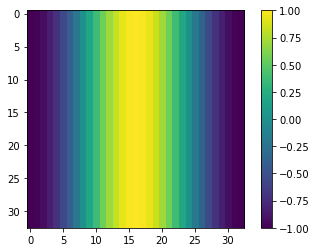

In [5]:
'''Plot the rhs in 2D'''
plt.imshow(rhs)
plt.colorbar()

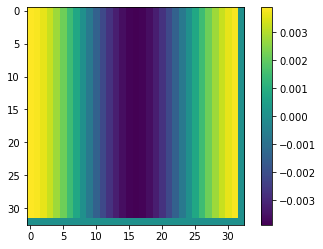

In [6]:
rhs_fem = prob.f
rhs_fem = rhs_fem.reshape(xx.shape)
plt.imshow(rhs_fem)
plt.colorbar()

In [7]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n+1)*(n+1))
res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
res_jacobi = [res]
print(n_jacobi, res)
while (res>EPS):
    prob.d = u_jacobi
    u_jacobi = prob.Relax(1)
    res = np.linalg.norm(prob.f - np.dot(prob.A,u_jacobi))
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

0 0.08782222854309034
1 0.08724328552100495
2 0.08661078851844005
3 0.08586031125972851
4 0.08506408817677628
5 0.08425656636694173
6 0.08345034138845991
7 0.08264969204725656
8 0.08185600965391417
9 0.08106971052185949
10 0.08029088498181317
11 0.07951951500748405
12 0.07875554689792462
13 0.07799891551679863
14 0.07724955236955905
15 0.07650738829168527
16 0.07577235434046725
17 0.07504438208799265
18 0.07432340371457417
19 0.07360935203569711
20 0.07290216050684734
21 0.07220176322100616
22 0.07150809490374009
23 0.07082109090752813
24 0.07014068720587381
25 0.06946682038738382
26 0.0687994276498734
27 0.06813844679451844
28 0.06748381622006051
29 0.06683547491706633
30 0.0661933624622422
31 0.06555741901280251
32 0.06492758530089306
33 0.06430380262806702
34 0.06368601285981487
35 0.0630741584201461
36 0.06246818228622344
37 0.0618680279830486
38 0.06127363957819893
39 0.060684961676614635
40 0.06010193941543619
41 0.05952451845889138
42 0.05895264499323118
43 0.05838626572171477
4

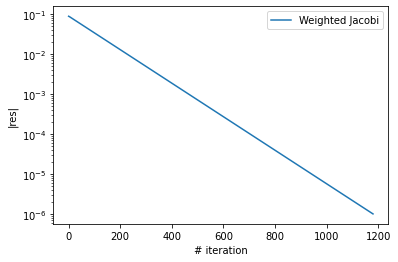

In [8]:
# Plot the residual evolution
plt.plot(res_jacobi, label='Weighted Jacobi')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('# iteration')
plt.ylabel('|res|')
plt.legend()

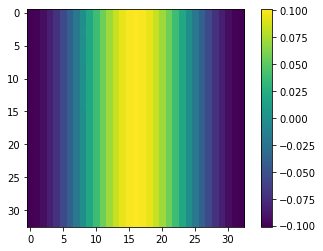

In [9]:
'''Plot the solution vector v in 2D'''
solution = prob.d
uu = solution.reshape(xx.shape)
plt.imshow(uu)
plt.colorbar()